> This notebook is an extension of Micrograd. We’ll add some cool features and enhancements to the core engine. It assumes you already understand the core

# <p style="font-family: Georgia; font-weight: normal; letter-spacing: 2px; color: #fabd2f;     font-size: 140%; text-align: left; padding: 0px; border-bottom: 3px solid #fabd2f;">Config</p>

make sure you installed requirements.txt

In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('../core')
from engine import Value

In [159]:
# I am also using custom seaborn style simply for better aesthetics
# you can ignore this part
# Gruvbox-inspired Seaborn configuration
from cycler import cycler

gruvbox_colors = [
    "#fb4934",  # red
    "#fabd2f",  # yellow
    "#b8bb26",  # green
    "#83a598",  # blue
    "#d3869b",  # purple
    "#fe8019",  # orange
    "#8ec07c",  # aqua
]

rc = {
    "axes.facecolor": "#282828",   # Dark background
    "figure.facecolor": "#282828", # Match figure bg
    "axes.edgecolor": "#3c3836",   # Softer border
    "grid.color": "#504945",       # Subtle grid lines
    "font.family": "arial",
    "axes.labelcolor": "#ebdbb2",  # Warm text
    "xtick.color": "#d5c4a1",
    "ytick.color": "#d5c4a1",
    "grid.alpha": 0.3,
    "axes.prop_cycle": cycler(color=gruvbox_colors), 
}

sns.set(rc=rc, style="darkgrid")

# <p style="font-family: Georgia; font-weight: normal; letter-spacing: 2px; color: #fabd2f;     font-size: 140%; text-align: left; padding: 0px; border-bottom: 3px solid #fabd2f;">Activation Functions</p>

In Andrew’s videos and repo, we already have tanh and ReLU implemented. These are simple, widely-used activations, but for deeper networks or transformers, more advanced activations can improve learning and gradient flow.

I will add:

* Leaky ReLU - fixes the "dying ReLU" problem
* GELU - smooth, probabilistic activation used in Transformers

## What is Leaky ReLU?


Lealy ReLU is a small modification of ReLU that allows a tiny, non-zero gradient when the input is negative:



f(x) =
\begin{cases} 
x & \text{if } x \ge 0 \\
\alpha x & \text{if } x < 0
\end{cases}


so the **derivative** is:

f'(x) =
\begin{cases} 
1 & \text{if } x \ge 0 \\
\alpha & \text{if } x < 0
\end{cases}


**Note:** Standard ReLU can "die" if a neuron only outputs negative values. Basically its gradient becomes 0, and learning stops. To avoid this Leaky ReLU helps us. It keeps small gradient (alpha) for negative values, thus improving training stability.

**Reference:** https://ai.stanford.edu/~amaas/papers/relu_hybrid_icml2013_final.pdf

![Leaky ReLU](../pics/LReLU.png)

How LReLU looks like:

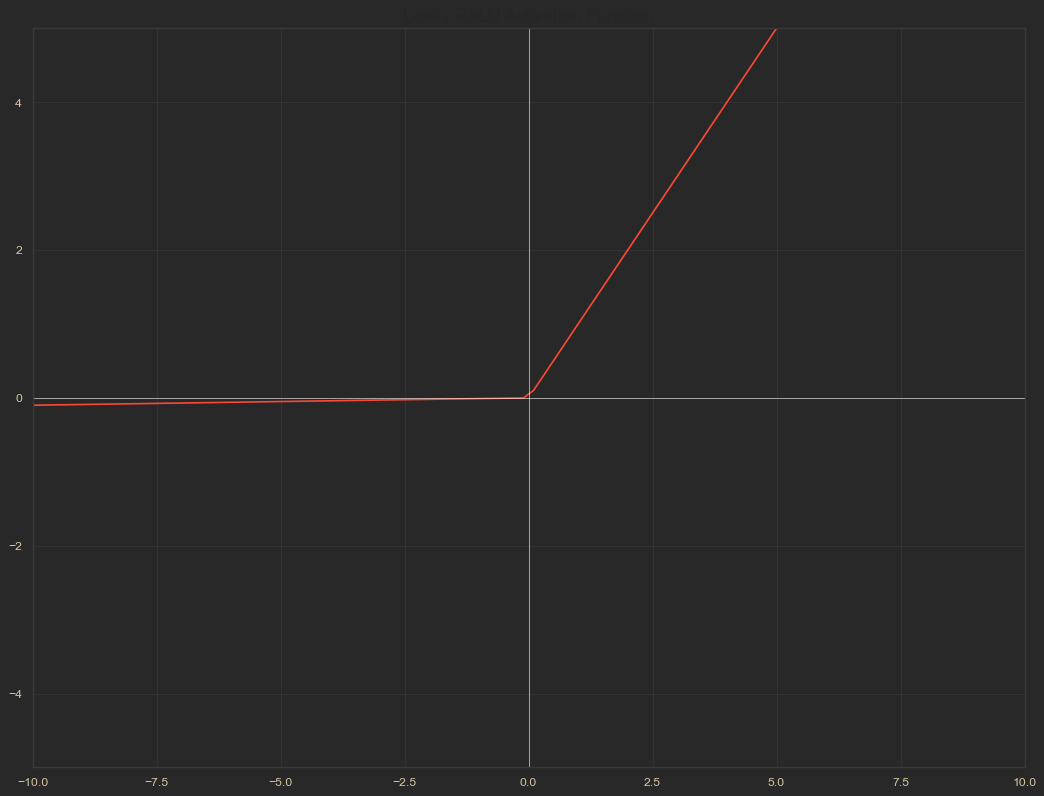

In [160]:
# pretty easy to visualize with matplotlib
# assume alpha is 0.01 (it can be any small value)
xs = np.linspace(-10, 10, 100)
ys = np.where(xs > 0, xs, 0.01 * xs)
plt.figure(figsize=(16, 12), dpi=80)
plt.plot(xs, ys)
plt.title("Leaky ReLU Activation Function", fontsize=16)
# set 0 a bit higher to see the negative slope
plt.ylim(-5, 5)
plt.xlim(-10, 10)
plt.axhline(0, color='white', lw=0.5)
plt.axvline(0, color='white', lw=0.5)
plt.show()

Just to see the difference, standard ReLU:

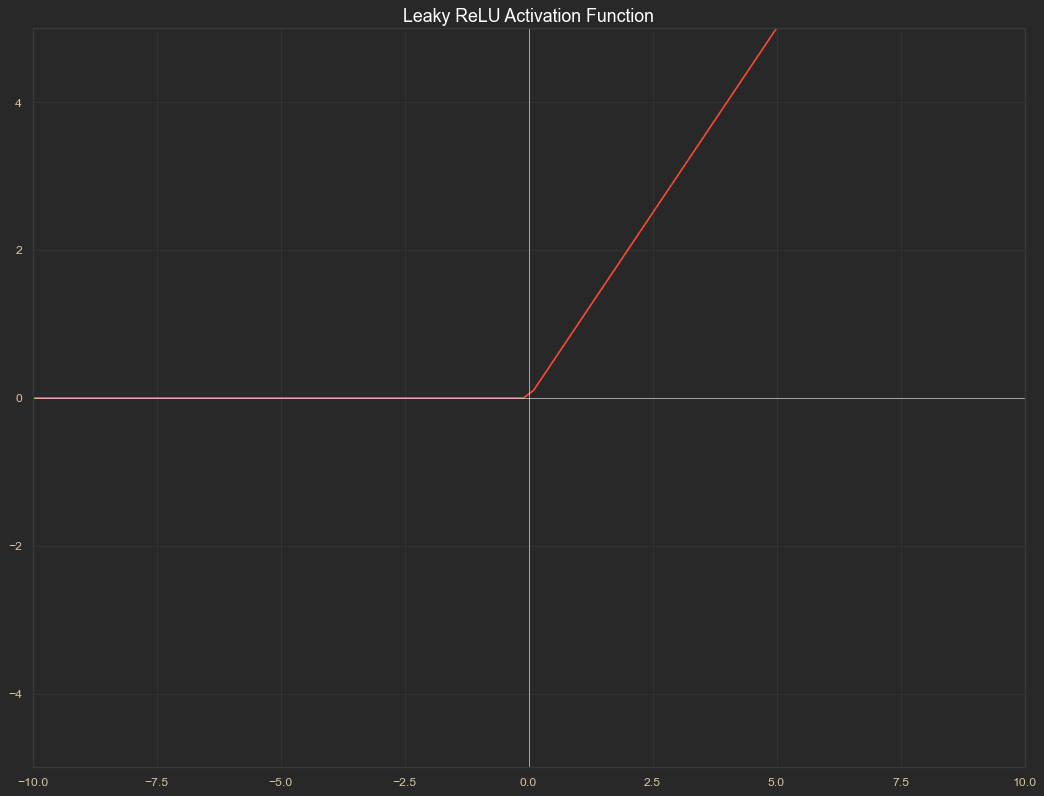

In [161]:
# For comparece, here is standard ReLU
ys_relu = np.where(xs > 0, xs, 0)
plt.figure(figsize=(16, 12), dpi=80)
plt.plot(xs, ys_relu)
plt.title("Leaky ReLU Activation Function", fontsize=16, color='white')
# set 0 a bit higher to see the negative slope
plt.ylim(-5, 5)
plt.xlim(-10, 10)
plt.axhline(0, color='white', lw=0.5)
plt.axvline(0, color='white', lw=0.5)
plt.show()

### Implementation of Leaky ReLU for micrograd:

In [162]:
#in micrograd, we can implement it like this, as a new method in the Value class:

# since formula is f(x) = x if x > 0 else alpha * x
# derivative is f'(x) = 1 if x > 0 else alpha

def leaky_relu(self, alpha=0.01):
    out = Value(self.data if self.data > 0 else alpha * self.data, (self,), 'lrelu')

    def _backward():
        self.grad += (1 if self.data > 0 else alpha) * out.grad # don't forget chain rule
    out._backward = _backward

    return out

# we can quickly test it (since it is implemented in my Value class, I can use it directly): 
a = Value(-4.0)
b = a.leaky_relu()
b.backward()
print(b)  # should be -0.04
print(a.grad)  # should be 0.01


Value(data=-0.04, grad=1)
0.01


## What is GELU?

GELU is Gaussian Error Linear Unit - sounds scary. I will try to explain it. Intuitionally you can think of it like this:

    “the bigger x is, the more it should contribute, but in a smooth, probabilistic way.”

### Mathematical Foundation of GELU:

The GELU (Gaussian Error Linear Unit) activation function is defined as:

$$
\text{GELU}(x) = x \cdot \Phi(x)
$$

where:  

- $x$ is the input,  
- $\Phi(x)$ is the cumulative distribution function (CDF) of the standard normal distribution. By definition CDF is just a distribution function $F_X(x)$ of $X$, evaluated at $x$ that shows the probability that $X$ will take a value **less than or equal to** $x$ 

$$ F_X(x) = P(X \le x) $$

  
- For reference on the standard normal CDF: [probability course](https://www.probabilitycourse.com/chapter4/4_2_3_normal.php)

- and [wiki page](https://en.wikipedia.org/wiki/Normal_distribution)


### Expanding Idea Further

Now the idea is that this CDF can be approximated using the error function

$$
\Phi(x) = \frac{1}{2} \left[ 1 + \text{erf}\left( \frac{x}{\sqrt{2}} \right) \right]
$$



So, GELU can be written as:

$$
\text{GELU}(x) = 0.5 \cdot x \left[ 1 + \text{erf}\left( \frac{x}{\sqrt{2}} \right) \right]
$$


**Why approximation??** Because then this approximation is **deterministic** because:

- The error function is a well-defined mathematical function, not a distribution function.  
- For any given input \(x\), the output is fixed and reproducible.

### Deterministic Nature of GELU

Nice, now we understand why despite its probabilistic-inspired formulation GELU is **deterministic**


**Note:** Being deterministic is **essential** because it allows us to:

- Compute derivatives reliably  
- Ensure consistent behavior during training and inference.

**Reference:** you can find the paper on GELU here https://arxiv.org/pdf/1606.08415v3

From pictures taken from this paper you can see visualization of GELU and how it outperforms other activation functions

![GELU](../pics/gelu_from_paper.png)

![GELU_MNIST](../pics/gelu_mnist.png)

Let's also plot GELU here:

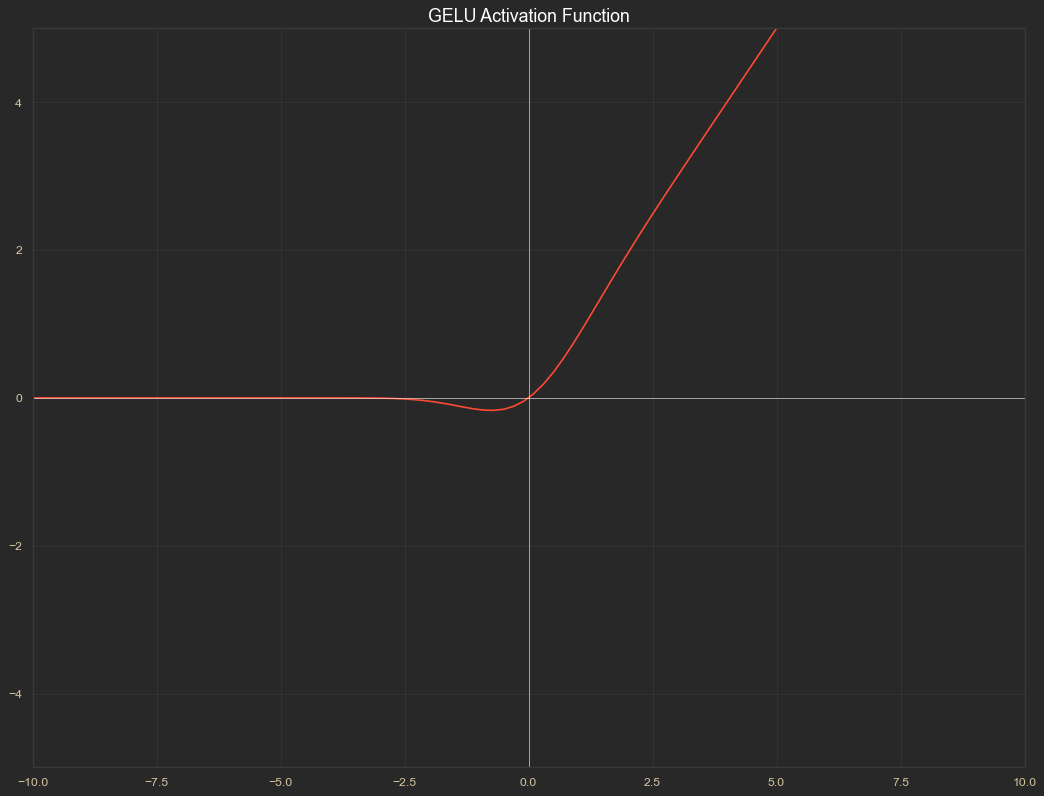

In [163]:
# Let's also plot GELU here: 
def gelu(x):
    """Gaussian Error Linear Unit activation function."""
    # This is how aproximation looks like from paper. You can read more in the reference section
    return 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * (x ** 3))))

ys_gelu = gelu(xs)
plt.figure(figsize=(16, 12), dpi=80)
plt.plot(xs, ys_gelu)
plt.title("GELU Activation Function", fontsize=16, color='white')
# set 0 a bit higher to see the negative slope
plt.ylim(-5, 5)
plt.xlim(-10, 10)
plt.axhline(0, color='white', lw=0.5)
plt.axvline(0, color='white', lw=0.5)
plt.show()

### Implementation of GELU for micrograd:

In [164]:
# now we can implement it in micrograd as well:
# this would be a bit tricky since we need to implement tanh as well (Andrew has it in vidoes but not on gitHub) 
def tanh(self):
    x = self.data
    t = (np.exp(2 * x) - 1) / (np.exp(2 * x) + 1)
    out = Value(t, (self,), 'tanh')

    def _backward():
        self.grad += (1 - t ** 2) * out.grad  # derivative of tanh is 1 - tanh^2(x)
    out._backward = _backward

    return out

# now we can implement GELU using this tanh
def gelu(self):
    """Gaussian Error Linear Unit activation function."""
    # This is how aproximation looks like from paper. You can read more in the reference section
    x = self.data
    tanh_out = (np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * (x ** 3)))) # calculate tanh part
    out = Value(0.5 * x * (1 + tanh_out), (self,), 'gelu')

    def _backward():
        # derivative of GELU is a quite a bit complex, so remember calculus classes!
        # since we have 0.5x * tanh_out that also uses x, so we use the chain rule here
        # don't forget that tanh_out is a complex function of x as well
        # derivative is gonna be:
        # 0.5 * (1 + tanh_out) + 0.5 * x * dtanh/dx 
        # where dtanh/dx = (1 - tanh^2(x)) * d(inner)/dx
        # and d(inner)/dx = sqrt(2/pi) * (1 + 3 * 0.044715 * x^2)
        dtanh = (1 - tanh_out ** 2)  # derivative of tanh
        dgelu_dx = 0.5 * (1 + tanh_out) + 0.5 * x * dtanh * np.sqrt(2 / np.pi) * (1 + 3 * 0.044715 * (x ** 2))
        self.grad += dgelu_dx * out.grad
        
    out._backward = _backward

    return out

In [165]:
# it's a bit to calculate manually, but we can test it like this:
a = Value(1.0)
b = a.gelu()
b.backward()
print(b)  # should be around 0.841
print(a.grad)  # should be around 1.083

# Actual calculations:

# For tanh_out x = 1.0:
# tanh_out = tanh(sqrt(2/pi) * (1 + 0.044715 * 1^3)) = tanh(0.7978845608 * 1.044715) = tanh(0.833)
# tanh(0.833) = 0.681
# So, b = 0.5 * 1 * (1 + 0.681) = 0.5 * 1.681 = 0.8405 (approximately 0.841)

# For gradient:
# dtanh = 1 - tanh_out^2 = 1 - 0.681^2 = 1 - 0.464761 = 0.535239
# d(inner)/dx = sqrt(2/pi) * (1 + 3 * 0.044715 * 1^2) = 0.7978845608 * (1 + 0.134145) = 0.7978845608 * 1.134145 = 0.904
# dgelu_dx = 0.5 * (1 + 0.681) + 0.5 * 1 * 0.535239 * 0.904 = 0.5 * 1.681 + 0.5 * 0.484 = 0.8405 + 0.242 = 1.082
# So, a.grad = 1.082 (approximately 1.083)

Value(data=0.8411919906082768, grad=1)
1.0829640838457826


# <p style="font-family: Georgia; font-weight: normal; letter-spacing: 2px; color: #fabd2f;     font-size: 140%; text-align: left; padding: 0px; border-bottom: 3px solid #fabd2f;">Enhanced MLP Components</p>



Next I would like to enhance MLP components or `nn.py` file of micrograd. Specifically add those:

- **Base Layer:** all layers inherit a parameters() method
- **Linear layer:** funny connected layer
- **Sequential container:** chain layers together
- **LayerNorm:** stabilize training by normalizing activations
- **Dropout:** regularization

We will get throught all of them one by one!
By the end, even thought these additions make the architecture slightly more complex, they allow faster convergence, smoother gradients, and better generalization!


### Base Layer

Base Layer is the simplest and an abstract layer. All the others will inherit from it.

* It provides a `parameters()` method for collecting all trainable parameters of a layer
* So we can, for example, access `update(p) for p in model.parameters()`

By having this base layer, any new layer we add, whether Linear, LayerNorm, Dropout or even something else, will follow the same micrograd principlese of tracking `Value` objects and building the computation graph.

In [166]:
# To implement base layer class we can do something like this:
class Layer:
    def parameters(self):
        return []  # By default, no parameters
    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0

### Linear Layer

Linear Layer (also known as fully connected or dense layer) would be the modern equivalent of Andrew's `Neuron`. Key difference, instead of handling one neuron at a time, a Linear layer computes a fully connected transformation from the input to the output.

It stores all weights and biases as `Value` objects, preserving the gradient tracking. Additionally Nonlinearities are separated from the Linear layer, which allows us to plug in any activation function we like (ReLU, LeakyReLU, GELU, etc.), making the network more modular and easier to experiment with.

**Note:**
* PyTorch has Linear layer: https://docs.pytorch.org/docs/stable/generated/torch.nn.Linear.html
* There is also a great documentation by NVIDIA: https://docs.nvidia.com/deeplearning/performance/dl-performance-fully-connected/index.html

![nvidia_linear](../pics/nvidia_linear.png)

In [167]:
# Let's implement Linear layer for our micrograd pro:
class Linear(Layer):
    def __init__(self, in_features, out_features, bias=True):
        self.weights = [Value(np.random.uniform(-1, 1)) for _ in range(in_features * out_features)]
        self.bias = [Value(0.0) for _ in range(out_features)] if bias else None
        
        self.in_features = in_features
        self.out_features = out_features
        self.has_bias = bias # decided to add this just like in PyTorch since it's a useful option for some layers
        
    def __call__(self, x):
        out = []
        for i in range(self.out_features):
            # Compute the dot product for the i-th output neuron
            start = i * self.in_features
            end = start + self.in_features
            neuron_weights = self.weights[start:end]
            neuron_output = sum(w * xi for w, xi in zip(neuron_weights, x))
            if self.has_bias:
                neuron_output += self.bias[i]
            out.append(neuron_output)
        return out
    
    def parameters(self):
        # Collect weights and biases
        return super().parameters() + self.weights + (self.bias if self.has_bias else [])

However we are missing one important component here!

Right now `Linear` layer computes outputs using `Value` objectsm, so **forward pass** works, but the outputs **don't** define their own `_backward` function that distributes gradients back to `weights`, `bias`, and `x`.

In other words, we are missing necessary `_backward` defined for each `Value`, since autograd only knows how to backproparage through operations if each output knows its **dependency** on the inputs.

Here is how I decided to implement it, to track gradients for weights, biases and inputs, keeping micrograd philosophy:

In [168]:
class Linear(Layer):
    def __init__(self, in_features, out_features, bias=True):
        self.weights = [Value(np.random.uniform(-1, 1)) for _ in range(in_features * out_features)]
        self.bias = [Value(0.0) for _ in range(out_features)] if bias else None
        
        self.in_features = in_features
        self.out_features = out_features
        self.has_bias = bias # decided to add this just like in PyTorch since it's a useful option for some layers
        
    def __call__(self, x):
        out = []
        for i in range(self.out_features):
            # Compute the dot product for the i-th output neuron
            start = i * self.in_features
            end = start + self.in_features
            neuron_weights = self.weights[start:end]
            neuron_output = sum(w * xi for w, xi in zip(neuron_weights, x))
            if self.has_bias:
                neuron_output += self.bias[i]
            
            # Wrap neuron_output in Value with _prev and _backward
            def make_backward(neuron_weights=neuron_weights, neuron_output=neuron_output, x=x, bias=self.bias[i] if self.has_bias else None):
                # capture local variables in default to bind in closure
                out_val = neuron_output
                def _backward():
                    # propagete gradients to weights, inputs, and bias
                    for w, xi in zip(neuron_weights, x):
                        w.grad += xi.data * out_val.grad  # Gradient w.r.t. weights
                        xi.grad += w.data * out_val.grad  # Gradient w.r.t. inputs
                    if self.has_bias:
                        bias.grad += out_val.grad  # Gradient w.r.t. bias
                out_val._backward = _backward
                return out_val
            
            out.append(make_backward())
            
        return out
    
    def parameters(self):
        # Collect weights and biases
        return super().parameters() + self.weights + (self.bias if self.has_bias else [])

Thus:

1. Each output neuron `Value` now knows which **weight**, **bias**, and **input** contributed to it (`_prev` is set implicitly via closure)
2. `_backward` implements the **chain rule**, distributing the gradient from the output to each weight, bias, and input
3. When you call `loss.backward()`, the gradients flow correctly thought all parameters, just like in micrograd.

In [169]:
# LET'S TEST IT!
# Create a Linear layer with 3 inputs and 2 outputs
layer = Linear(3, 2)
# Create a sample input (3 features)
x = [Value(1.0), Value(-2.0), Value(3.0)]

# --- First Pass ---

# Forward pass
out = layer(x)
print("Output:", out)
print("Output grads before backward:", [o.grad for o in out])
# Assume some loss (sum of outputs for simplicity)
loss = out[0] + out[1]
# Backward pass
loss.backward()
# Print gradients
# weights, biases, and inputs should have gradients now
for i, w in enumerate(layer.weights):
    print(f"Weight {i} gradient: {w.grad}")
if layer.has_bias:
    for i, b in enumerate(layer.bias):
        print(f"Bias {i} gradient: {b.grad}")
for i, xi in enumerate(x):
    print(f"Input {i} gradient: {xi.grad}")

Output: [Value(data=0.14753925386048428, grad=0), Value(data=-1.1374958763022087, grad=0)]
Output grads before backward: [0, 0]
Weight 0 gradient: 1.0
Weight 1 gradient: -2.0
Weight 2 gradient: 3.0
Weight 3 gradient: 1.0
Weight 4 gradient: -2.0
Weight 5 gradient: 3.0
Bias 0 gradient: 1
Bias 1 gradient: 1
Input 0 gradient: 0.4565201591641068
Input 1 gradient: 0.9729644179667623
Input 2 gradient: 0.16648401810923108


In [170]:
# --- Second Pass ---
# Zero gradients
layer.zero_grad()
for xi in x:
    xi.grad = 0
# Forward pass again
out = layer(x)
print("Output (2nd pass):", out)
print("Output grads before backward (2nd pass):", [o.grad for o in out])
# Assume some loss change 
loss = out[0] + out[1] - 0.5 * out[0]  # just to change the loss a bit
# Backward pass second pass
loss.backward()

# Print gradients after second pass
print("Gradients after 2nd pass:")
for i, w in enumerate(layer.weights):
    print(f"Weight {i} gradient: {w.grad}")
if layer.has_bias:
    for i, b in enumerate(layer.bias):
        print(f"Bias {i} gradient: {b.grad}")
for i, xi in enumerate(x):
    print(f"Input {i} gradient: {xi.grad}")


Output (2nd pass): [Value(data=0.14753925386048428, grad=0), Value(data=-1.1374958763022087, grad=0)]
Output grads before backward (2nd pass): [0, 0]
Gradients after 2nd pass:
Weight 0 gradient: 0.5
Weight 1 gradient: -1.0
Weight 2 gradient: 1.5
Weight 3 gradient: 1.0
Weight 4 gradient: -2.0
Weight 5 gradient: 3.0
Bias 0 gradient: 0.5
Bias 1 gradient: 1
Input 0 gradient: 0.3202302259383699
Input 1 gradient: 0.5051906095204712
Input 2 gradient: -0.12452508542313134


Result!

We can see that after 2nd pass we got exactly what we wanted. We changed the loss function only by `-0.5*out[0]`. 

This effectively changes the derivative w.r.t each weight and bias. For example, the derivative of `-0.5*out[0] `contributes -0.5 times the original derivative of `out[0]`, hence the halving of some gradients like weight 0, weight 2, weight 3, bias 0, and inputs

### Sequential Container

Sequential Container is the next abstruction step in architecture allowing us to stack multiple layers in a linear fashion. 

In Andrew’s original MLP, each layer (made of neurons) is manually chained in the `__call__` function:
```python
def __call__(self, x):
    for layer in self.layers:
        x = layer(x)
    return x
```

This works fine, but as we add more complex layers (like Dropout or LayerNorm), we want a cleaner, modular way to stack them, similar to how PyTortch's `nn.Sequential` works.

A `Sequential` container allows us to:

* Chain multiple layers in order
* Treat the entire sequence as a single module
* Easily collect parameters from all internal layers for optimization

For example we can have single Sequential Layer look like this:
```python
model = Sequential(
    Linear(2, 8),
    GELU(), # hypothetical activation function
    Linear(8, 1)
)
```

**Reference:** https://docs.pytorch.org/docs/stable/generated/torch.nn.Sequential.html

In [171]:
# Let's implement Sequential container for micrograd pro:
class Sequential(Layer):
    def __init__(self, *layers):
        # Store layers in a list
        self.layers = layers
        
    def __call__(self, x):
        # Pass input through each layer in sequence
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        # Collect parameters from all layers
        params = []
        for layer in self.layers:
            params.extend(layer.parameters())
        return params
    
    # Also add repr for better visualization
    def __repr__(self):
        layer_reprs = ", ".join([layer.__class__.__name__ for layer in self.layers])
        return f"Sequential({layer_reprs})"

In [172]:
# Let's test with a simple example:
# Create a simple model with 2 Linear layers
model = Sequential(
    Linear(4, 8),  # Input layer: 4 features to 8 neurons
    Linear(8, 1)   # Output layer: 8 neurons to 1 output features
)

x = [Value(0.5), Value(-1.5), Value(2.0), Value(1.0)]  # Example input with 4 features
output = model(x)  # Forward pass
print("Model output:", output)
print("Model number of parameters:", len(model.parameters())) # should be 4*8 + 8 + 8*1 + 1 = 32 + 8 + 8 + 1 = 49

Model output: [Value(data=3.6028742119667463, grad=0)]
Model number of parameters: 49


### LayerNorm

Many of you probably heard of Batch Normalization, I definetly heard and used it before understanding Layer Normalization.

The original problem accured 10 or even more years ago, when neural networks became deeper and deeper, and researchers noticed that activations in intermediate layers often *drift*, some neurons produce very large outputs, while others saturate. That's when **Batch Normalization** was introduced in 2015. It literally normalizes activations across the *batch dimension*.

However, BatchNorm has limitations:
- It depends on batch size, small batches make it unreliable
- It behaves differently during training and **inference**
- It's not well-suited for **RRNs** or **Transformers**

*Reference:* BatchNorm - https://arxiv.org/pdf/1502.03167

Thus a Layer Normalization came to life. A Better Alternative 

Literally Layer Normalization was proposed as a batch-size-independent alternative.
Instead of normalizing across samples, it normalizes across the features of a single sample, treating every individual input vector as its own "mini-batch."

So for a single input $x = [x_1, x_2, ... , x_d]$:

$$
\mu = \frac{1}{d} \sum_{i=1}^{d} x_i, \quad
\sigma^2 = \frac{1}{d} \sum_{i=1}^{d} (x_i - \mu)^2
$$

Then, the normalized and scaled outputs are:

$$
\hat{x}_i = \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}}, \quad
y_i = \gamma_i \hat{x}_i + \beta_i
$$

Here:
- $\hat{x}_i$ (gain) and  $\beta_i$ (bias) are learnable parameters per feature
- $\epsilon$ ensures numerical stability

**Note:** Unlike Batch Norm,
- There is no dependency on batch statistics
- It works identically during training and inference
- It can be used in any setting (transformers, RNNs, etc.)

*Reference:* LayerNorm - https://arxiv.org/pdf/1607.06450

### Why LayerNorm?

LayerNorm became a **cornerstone** in modern deep learning, especially:
- In **Transformers** (e.g., BERT, GPT, ViT), applied before or after each attention/feed-forward block
- In **language models** and **sequence models**, where per-token normalization ensures stable gradients
- In small-batch or online learning setups, since BatchNorm fails in small batch sizes

Typical structure in transformer layers looks like this:

```python
x = x + MLP(LayerNorm(x))

# or sometimes

x = LayerNorm(x + MLP(x))
```

There are several reasons why I wanted to implement LayerNorm in `micrograd_pro`

1. It's **relevant**, used in today's modern technologies

2. **Batch independence**, micrograd and micrograd_pro are scalar-based and process one sample at a time

3. **Conceptual clarity**, LayerNorm focuses on the feature dimension, aligning perfectly with how our `Value` based computation graph represents individual samples.

So, with all that in mind, let's finalize:

$$
\text{LayerNorm}(x) = \gamma \cdot \frac{x - \mu}{\sqrt{\sigma^2 + \epsilon}} + \beta
$$

where:

- $\mu$ = mean across features  
- $\sigma^2$ = variance across features  
- $\gamma, \beta$ = trainable parameters

**Reference**: PyTorch LayerNorm - https://docs.pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html

In [173]:
# Now let's implement LayerNorm for micrograd pro:
class LayerNorm(Layer):
    def __init__(self, normalized_shape, eps=1e-5):
        # normalized_shape can be an int or a tuple of ints
        if isinstance(normalized_shape, int):
            normalized_shape = (normalized_shape,)
        self.normalized_shape = normalized_shape
        self.eps = eps
        self.gamma = [Value(1.0) for _ in range(np.prod(normalized_shape))]  # Scale parameter
        self.beta = [Value(0.0) for _ in range(np.prod(normalized_shape))]   # Shift parameter
        
    def __call__(self, x):
        # a little bit of math here
        # x is a list of Value objects
        # 1. Calculate mean
        mean = sum(xi.data for xi in x) / len(x)
        # 2. Calculate variance
        variance = sum((xi.data - mean) ** 2 for xi in x) / len(x)
        # 3. Normalize
        normalized = [(xi.data - mean) / np.sqrt(variance + self.eps) for xi in x]
        # 4. Scale and shift
        out = [Value(gam * norm + bet, (xi,), 'layernorm') for xi, norm, gam, bet in zip(x, normalized, self.gamma, self.beta)]
        return out
    
    def parameters(self):
        return super().parameters() + self.gamma + self.beta
        

### Derivation LayerNorm

Same way as with Linear layer we need to take care of gradients.

LayerNorm gradients are trickier because the output depends on **all inputs simultaneously** (mean and variance), so each input's gradient is affected by every other input. However, conceptually it's the same workflow as Linear: define the forward pass, then implement the backward pass using the chain rule

There is more math involved in this solution, so I would like to go a little bit deeper into it than the one for Linear layer. Please don't be scared of math!

So my intuition would be this. 

Given 2 formulas of normalization step and learnable affine transformation:

$$
\hat{x}_i = \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}}, \quad
y_i = \gamma_i \hat{x}_i + \beta_i
$$

Where:

- $\mu = \frac{1}{d}\sum_i{x_i}$

- $\sigma^2 = \frac{1}{d}\sum_i{(x_i - \mu)^2}$

- $d = \text{number of features}$

- $\gamma_i, \beta_i \ are \ learnable$ - scale and shift


Thus, we need to find:

1.	$\frac{\partial y_i}{\partial \gamma_i} = \hat{x}_i$ - gradient for gamma
2.	$\frac{\partial y_i}{\partial \beta_i} = 1$ - gradient for beta
3.	$\frac{\partial y_i}{\partial x_i}$ - more complex because $x_i$ affects $\hat{x}_i$ through both $\mu$ and $\sigma^2$

So to derive gradients for $x_i$ , $\gamma_i$, and $\beta_i$, given the loss $L$:

1. $\frac{\partial L}{\partial y_i} = g_i$

2. $\frac{\partial L}{\partial \beta_i} = g_i$

3. $\frac{\partial L}{\partial \gamma_i} = g_i \cdot \hat{x}_i$


Now we want the gradient of the loss $L$ with respect to an input feature $x_i$ for Layer Normalization.

Recall the forward equations for one input vector $\mathbf{x}=(x_1,\dots,x_d)$:


$\mu = \frac{1}{d}\sum_{j=1}^{d} x_j, \qquad \sigma^2 = \frac{1}{d}\sum_{j=1}^{d} (x_j - \mu)^2,$ 

$\hat{x}_i = \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}}, \qquad y_i = \gamma_i \hat{x}_i + \beta_i.$

Let, $g_i \equiv \frac{\partial L}{\partial y_i}$ be the upstream gradient at $y_i$.

From the affine transform $y_i = \gamma_i \hat{x}_i + \beta_i$ 

We get:

$\frac{\partial L}{\partial \beta_i} = g_i, \qquad \frac{\partial L}{\partial \gamma_i} = g_i \hat{x}_i,$ 

and the gradient flowing into $(\hat{x}_i)$ is $\hat{g}_i \equiv \frac{\partial L}{\partial \hat{x}_i} = g_i \gamma_i.$

So the remaining task is to compute $(\dfrac{\partial L}{\partial x_i} = \sum_{k=1}^{d} \hat{g}_k \dfrac{\partial \hat{x}_k}{\partial x_i}).$

---

1. **We want to compute $(\dfrac{\partial \hat{x}_k}{\partial x_i})$**

$$
\frac{\partial \hat{x}_k}{\partial x_i}
= \frac{\partial}{\partial x_i}\left(\frac{x_k - \mu}{s}\right)
= \frac{1}{s}\frac{\partial (x_k - \mu)}{\partial x_i}
(x_k - \mu) \frac{\partial (1/s)}{\partial x_i}.
$$


What I did here is write $(\hat{x}_k = \dfrac{x_k - \mu}{s})$ with $(s \equiv \sqrt{\sigma^2 + \epsilon}).$


Then handle this derivative piecewise. 

First, note easy part:

We know $\mu = \frac{1}{d}\sum_j x_j$, so

$\frac{\partial \mu}{\partial x_i} = \frac{1}{d}.$

Therefore,

$$
\frac{\partial (x_k - \mu)}{\partial x_i}
= \frac{\partial x_k}{\partial x_i} - \frac{1}{d}
= \delta_{ki} - \frac{1}{d}.
$$


After that, find $\frac{\partial s}{\partial x_i}$

We know for the variance, $\sigma^2 = \frac{1}{d}\sum_j (x_j - \mu)^2,$ differentiate w.r.t. $x_i$.

$$
\frac{\partial s}{\partial x_i} = \frac{1}{2s} \cdot \frac{2}{d}\sum_j (x_j - \mu) \frac{\partial (x_j - \mu)}{\partial x_i}.
$$

From before:

$$\frac{\partial s}{\partial x_i}
= \frac{1}{s d}\sum_j (x_j - \mu)(\delta_{ji} - \tfrac{1}{d}).$$

Simplify that:

$$
\frac{\partial s}{\partial x_i}
= \frac{1}{s d}\left((x_i - \mu) - \tfrac{1}{d}\sum_j (x_j - \mu)\right)
= \frac{1}{s d}(x_i - \mu),
$$

Because $(\sum_j (x_j-\mu)=0)$, the cross term vanishes and you get $\frac{\partial \sigma^2}{\partial x_i} = \frac{2}{d}(x_i - \mu).$

Then,

$$
  \frac{\partial s}{\partial x_i} = \frac{1}{2s}\frac{\partial \sigma^2}{\partial x_i}
  = \frac{1}{2s} \cdot \frac{2}{d}(x_i-\mu)
  = \frac{x_i - \mu}{d\,s}.
$$

$$
\frac{\partial (1/s)}{\partial x_i}
= -\frac{1}{s^2} \frac{\partial s}{\partial x_i}
= -\frac{(x_i - \mu)}{s^3 d}.
$$

Combine two parts, 

$$
\frac{\partial \hat{x}k}{\partial x_i}
= \frac{1}{s}(\delta{ki} - \tfrac{1}{d})
\frac{(x_k - \mu)}{s} \cdot \frac{(x_i - \mu)}{s^2 d}.
$$

Recognize that $\hat{x}_k = \frac{x_k - \mu}{s},$ so:


$$
\boxed{\displaystyle
\frac{\partial \hat{x}_k}{\partial x_i} \;=\; \frac{1}{s}\Big(\delta_{ki} - \tfrac{1}{d} - \tfrac{1}{d}\,\hat{x}_k\hat{x}_i\Big)
}
$$


2. **Combine with $(\hat{g}_k)$ to get $(\dfrac{\partial L}{\partial x_i})$**

Now sum over $k$:

$$
\frac{\partial L}{\partial x_i}
= \sum_{k=1}^d \hat{g}_k \frac{\partial \hat{x}_k}{\partial x_i}
= \sum_k \hat{g}_k \cdot \frac{1}{s}\Big(\delta_{ki} - \tfrac{1}{d} - \tfrac{1}{d}\,\hat{x}_k\hat{x}_i\Big).
$$

Separate the terms, distribute the sum, we get rid of Kronecker delta:

$$
\frac{\partial L}{\partial x_i}
= \frac{1}{s}\Big(
\hat{g}_i
- \frac{1}{d}\sum_k \hat{g}_k
- \frac{\hat{x}_i}{d}\sum_k \hat{g}_k \hat{x}_k
\Big).
$$

Finally substitute $(\hat{g}_k = g_k \gamma_k)$ and $(s=\sqrt{\sigma^2+\epsilon})$ to obtain the commonly used compact form:

$$
\boxed{\displaystyle
\frac{\partial L}{\partial x_i}
=
\frac{1}{\sqrt{\sigma^2+\epsilon}}\left(
g_i \gamma_i
- \frac{1}{d}\sum_{j=1}^d g_j \gamma_j
- \frac{\hat{x}_i}{d}\sum_{j=1}^d g_j \gamma_j \hat{x}_j
\right)
}
$$

---

**Short intuition**

- The first term $\frac{g_i \gamma_i}{s}$ (or $\frac{g_i \gamma_i}{\sqrt{\sigma^2+\epsilon}}$ ) is the **direct** sensitivity of the loss to $x_i$.
- The second term subtracts the **mean effect** because the mean $\mu$ depends on every $x_j$.
- The third term corrects for the effect of $x_i$ on the variance through $\hat{x}_i$, which couples all features together.

In [174]:
# Let's implement LayerNorm class with backward method: 

class LayerNorm(Layer):
    def __init__(self, normalized_shape, eps=1e-5):
        # normalized_shape can be an int or a tuple of ints
        if isinstance(normalized_shape, int):
            normalized_shape = (normalized_shape,)
        self.normalized_shape = normalized_shape
        self.eps = eps
        
        n= int(np.prod(normalized_shape))
        self.gamma = [Value(1.0) for _ in range(n)]  # Scale parameter
        self.beta = [Value(0.0) for _ in range(n)]   # Shift parameter
        
    def __call__(self, x):
        """
        x: list of Value objects (length d)
        returns: list of Value objects y_i = gamma_i * hat_x_i + beta_i
        where hat_x_i = (x_i - mu) / sqrt(sigma^2 + eps)
        """
        d = len(x)
        # 1. Calculate mean and variance as scalars
        mean = sum(xi.data for xi in x) / d
        var = sum((xi.data - mean) ** 2 for xi in x) / d
        s = np.sqrt(var + self.eps) # s == sqrt(sigma^2 + eps)
        
        # 2. Compute normalized values hat_x as floats
        hat = [(xi.data - mean) / s for xi in x]
        
        # 3. Crate output Value objects (data computed from gamma and beta)
        outs = []
        for i, (xi, gi, bi) in enumerate(zip(x, self.gamma, self.beta)):
            out_val = Value(gi.data * hat[i] + bi.data, _children=(xi, gi, bi), _op='layernorm')
            outs.append(out_val)
            
        # 4. Define backward for each output. Each backward uses *current* outs[j].grad
        # since xi.grad depends on sums over all g_j * gamma_j etc.
        def make_backward(i, xi=None, gi=None, bi=None):
            # bind referenced objects in closure
            xi = x[i]
            gi = self.gamma[i]
            bi = self.beta[i]
            def _backward():
                # upstream gradients for y_j (these may have been accumulated already)
                g_list = [oj.grad for oj in outs] # g_j = dL/dy_j
                
                # precompute sums used in formuala:
                # sum1 = sum_j g_j * gamma_j
                # sum2 = sum_j g_j * gamma_j * hat_x_j
                sum1, sum2 = 0.0, 0.0
                for j, gj in enumerate(g_list):
                    sum1 += gj * self.gamma[j].data
                    sum2 += gj * self.gamma[j].data * hat[j]
                    
                # local values
                s_val = s # sqrt(var + eps)
                hat_i = hat[i] # hat_x_i
                g_i = g_list[i] # dL/dy_i
                gamma_i = gi.data # gamma_i
                
                # d_beta_i = g_i
                bi.grad += g_i
                
                # d_gamma_i = g_i * hat_i
                gi.grad += g_i * hat_i
                
                # d_x_i = (1/s) * (g_i * gamma_i - (1/d) * sum1 - (hat_i/d) * sum2)
                dx_i = (1 / s_val) * (g_i * gamma_i - (1/d) * sum1 - (hat_i / d) * sum2)
                xi.grad += dx_i
                
            return _backward

        for i, out_val in enumerate(outs):
            out_val._backward = make_backward(i)
            
        return outs
    
    def parameters(self):
        return super().parameters() + self.gamma + self.beta        

In [175]:
# Let's test LayerNorm with a simple example:
# Create inputs and LayerNorm
x = [Value(1.0), Value(2.0), Value(4.0), Value(5.0)]
ln = LayerNorm(4)

# Set some "learned" gamma and beta to mimic training
ln.gamma = [Value(2.0), Value(1.5), Value(1.0), Value(0.5)]
ln.beta  = [Value(0.0), Value(1.0), Value(-1.0), Value(0.5)]

# Forward pass
out = ln(x)
print("LayerNorm output:", out)

# Compute simple scalar loss (sum of outputs)
loss = sum(out)

# Backward pass
loss.backward()

# Inspect gradients
print("\nGradients after first backward pass:")
print("x grads:", [xi.grad for xi in x])
print("gamma grads:", [g.grad for g in ln.gamma])
print("beta grads:", [b.grad for b in ln.beta])

# Zero gradients to prepare for second pass
ln.zero_grad()  # clears gamma and beta grads
for xi in x:
    xi.grad = 0

# Forward pass again 
out = ln(x)
print("\nLayerNorm output (2nd pass):", out)

# Backward pass second pass
# can also change loss slightly if you want to see different gradients
loss = sum(out) + 0.1 * out[0] - 0.4 * out[2]
loss.backward()

# Inspect gradients after second pass
print("\nGradients after second backward pass:")
print("x grads:", [xi.grad for xi in x])
print("gamma grads:", [g.grad for g in ln.gamma])
print("beta grads:", [b.grad for b in ln.beta])

# inspect changes in gradients considering out[0] and out[2] contributions

LayerNorm output: [Value(data=-2.529817068505626, grad=0), Value(data=0.05131859931039018, grad=0), Value(data=-0.3675457328735935, grad=0), Value(data=1.1324542671264064, grad=0)]

Gradients after first backward pass:
x grads: [np.float64(0.03162448422118484), np.float64(-0.06324454128020839), np.float64(0.06324454128020839), np.float64(-0.03162448422118484)]
gamma grads: [np.float64(-1.264908534252813), np.float64(-0.6324542671264065), np.float64(0.6324542671264065), np.float64(1.264908534252813)]
beta grads: [1, 1, 1, 1]

LayerNorm output (2nd pass): [Value(data=-2.529817068505626, grad=0), Value(data=0.05131859931039018, grad=0), Value(data=-0.3675457328735935, grad=0), Value(data=1.1324542671264064, grad=0)]

Gradients after second backward pass:
x grads: [np.float64(0.08854577303167331), np.float64(-0.02529718406034597), np.float64(0.10435535884496894), np.float64(0.08221708147701244)]
gamma grads: [np.float64(-1.3913993876780943), np.float64(-0.6324542671264065), np.float64(0.37

In [176]:
# let's test LayerNorm with a simple example:
layer_norm = LayerNorm(normalized_shape=4)  # Normalize over 4 features
x = [Value(1.0), Value(2.0), Value(3.0), Value(4.0)]
output = layer_norm(x)
print("LayerNorm output:", output)
print("LayerNorm number of parameters:", len(layer_norm.parameters()))  # should be 8 because we have 4 gamma and 4 beta

# x = [Value(1.0), Value(2.0), Value(3.0), Value(4.0)]
# Mean = (1 + 2 + 3 + 4) / 4 = 2.5
# Variance = [(1-2.5)² + (2-2.5)² + (3-2.5)² + (4-2.5)²] / 4 = [2.25 + 0.25 + 0.25 + 2.25] / 4 = 5 / 4 = 1.25
# Standard Deviation = sqrt(1.25 + 1e-5) ≈ 1.118
# Normalized values:
# (1 - 2.5) / 1.118 ≈ -1.3416
# (2 - 2.5) / 1.118 ≈ -0.4472
# (3 - 2.5) / 1.118 ≈ 0.4472
# (4 - 2.5) / 1.118 ≈ 1.3416
# Since gamma is initialized to 1 and beta to 0, the final output values will be approximately:
# Value(-1.3416), Value(-0.4472), Value(0.4472), Value(1.3416)
# After gamma and beta are "learned" during training, the output values will be scaled and shifted accordingly.

LayerNorm output: [Value(data=-1.3416354199689269, grad=0), Value(data=-0.447211806656309, grad=0), Value(data=0.447211806656309, grad=0), Value(data=1.3416354199689269, grad=0)]
LayerNorm number of parameters: 8


### Dropout

Dropout is a regularization technique used to prevent overfitting.

Basically during training, it randomly "drops" (sets to zero) a fraction of neurons` outputs in a layer, so that the network cannot rely too heavily on a single neuron.

**Note:** 
- During inference, no neurons are dropped, but outputs are typically scaled to account for the dropped fraction during training

How it works (training vs inference):
- Training: Each neuron has probability p of being kept (or 1-p of being dropped). Multiply the remaining outputs by 1/p to keep expected value unchanged.
- Inference: Keep all neurons active, no scaling needed (or just multiply by p depending on convention).

**Reference:**
- Original paper: https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf
- torch.nn.Dropout: https://docs.pytorch.org/docs/stable/generated/torch.nn.Dropout.html


![dropout](../pics/dropout.png)

### Why Dropout?

- Forces the network to learn redundant representations of the data
- Reduces co-adaptation of neurons, each neuron has to be useful independently
- Works well in fully connected layers, and sometimes in other layers like embeddings



Even though dropout is mostly historical / pedagogical in **modern** deep learning, I think it's still valuable to understand, experiment with it and do some testing in micrograd engine.

- For NLP in BERT, GPT, etc. dropout is mostly applied only to **embeddings or attention weights**, and sometimes only in the feed-forward blocks
- In Diffusion models rarely used since mechanisms like **noise injection** serve a similar regularization role
- In general dropout nowadays is not as important since models are trained with **very large datasets**, so overfitting is less of an issue. 

**However**: I still think it's an important concept and we shouldn't skip it entirely! Especially since in context of micrograd we are dealing with small datasets

In [177]:
# Let's implement dropout for micrograd pro:
# need to import random module
import random
class Dropout(Layer):
    def __init__(self, p=0.1, seed=None):
        self.p = p # dropout probability
        self.training = True # by default, we are in training mode
        # wanted to implement seed as well
        if seed is not None:
            random.seed(seed)
    
    def __call__(self, x):
        if self.training:
            # dropout mask is for each element in x, 0 with prob p, 1 with prob (1-p)
            self.mask = [0 if random.random() < self.p else 1 for _ in x]  # Store mask for backward pass
            # from wikipedia bernoulli distribution
            out = [xi * m / (1 - self.p) for xi, m in zip(x, self.mask)]
        else:
            out = x  # during evaluation, do nothing
    
        # we don't need to implement backward since dropout is not learnable and does not have parameters
        return out
    
    
    def parameters(self):
        return super().parameters()  # no parameters in dropout

In [178]:
# let's test it:
# assume Value and Layer are defined above
x = [Value(1.0), Value(2.0), Value(3.0), Value(4.0)]

drop = Dropout(p=0.25, seed=42)  # reproducible
drop.training = True

out = drop(x)
print("Output:", [o.data for o in out])
print("Mask used:", drop.mask)

# simple loss (sum of outputs)
loss = sum(out)
loss.backward()

# 	p = 0.25 (drop probability)
# Keep probability = 1 - p = 0.75
# Scaling factor = 1 / (1 - p) = 1 / 0.75 = 4/3 or 1.3333
print("Input grads:", [xi.grad for xi in x])

# Turn off dropout for inference
drop.training = False
out_eval = drop(x)
print("Eval output:", [o.data for o in out_eval])

Output: [1.3333333333333333, 0.0, 4.0, 0.0]
Mask used: [1, 0, 1, 0]
Input grads: [1.3333333333333333, 0.0, 1.3333333333333333, 0.0]
Eval output: [1.0, 2.0, 3.0, 4.0]


# <p style="font-family: Georgia; font-weight: normal; letter-spacing: 2px; color: #fabd2f;     font-size: 140%; text-align: left; padding: 0px; border-bottom: 3px solid #fabd2f;">Building Custom Optimizer</p>



To be added later...

# <p style="font-family: Georgia; font-weight: normal; letter-spacing: 2px; color: #fabd2f;     font-size: 140%; text-align: left; padding: 0px; border-bottom: 3px solid #fabd2f;">Conclusion</p>


### Key Takeaways

- Enhanced the original micrograd engine with:
	- Custom activation functions: GELU, LeakyReLU, tanh
	- A flexible Linear layer with bias handling
	- Sequential container for stacking layers
	- LayerNorm with correct backward implementation
	- Dropout with training/eval modes and seeding
- Built a foundation for experimenting with gradient flow and MLP architectures.
- This notebook sets the stage for adding custom optimizers (SGD, Adam, RMSProp)


### Things to do next
- Check out my `gradient_flow` notebook with:
	- Training loops and loss tracking
	- Visualization of gradient magnitudes and flow


### Acknowledgements / References
- micrograd repository — core inspiration
- Papers & concepts referenced for activations and normalization:
	- Hendrycks & Gimpel (2016), Gaussian Error Linear Units (GELU)
	- Ba et al. (2016), Layer Normalization
	- Maas, A. L., Hannun, A. Y., & Ng, A. Y. (2013). Rectifier Nonlinearities Improve Neural Network Acoustic Models
	- He, K., Zhang, X., Ren, S., & Sun, J. (2015). Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification
	- Srivastava, N., Hinton, G., Krizhevsky, A., Sutskever, I., & Salakhutdinov, R. (2014). Dropout: A Simple Way to Prevent Neural Networks from Overfitting.
	- possibly more, check out resources.md in the gitHub repo for this project
Overfitting
- PyTorch documentation

**Note:** This notebook was developed as a learning and experimentation tool, not production-ready code